In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

import datetime
from datetime import date

# Plots
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling

# Classifier's metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

### Retrieve data

In [2]:
# Read dataset
data_folder = './data/'
data=pd.read_csv(data_folder + 'marketing_campaign.csv',header=0,sep=';', index_col = 'ID')

In [3]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,4/9/2012,58,635,88,...,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,8/3/2014,38,11,1,...,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,21/8/2013,26,426,49,...,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,10/2/2014,26,11,4,...,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,19/1/2014,94,173,43,...,5,0,0,0,0,0,0,3,11,0


### Analyze data and rename columns

In [4]:
# Calculate client's age
data['Age'] = 2021 - data['Year_Birth']

# Calculate total spent
data['Total_Spent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

#Seniority variable creation
last_date = date(2021, 12, 13)

In [5]:
# Calculate clients's seniority
data['Seniority']=pd.to_datetime(data['Dt_Customer'], dayfirst=True, format='%d/%m/%Y')
data['Seniority'] = pd.to_numeric(data['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')

# Rename some columns
data=data.rename(columns={'NumWebPurchases': "Web_Purchases",
                          'NumCatalogPurchases':'Catalog_Purchases',
                          'NumStorePurchases':'Store_Purchases', 
                          'NumWebVisitsMonth':'Web_Visits_Month',
                          'MntWines': "Wines",
                          'MntFruits':'Fruits',
                          'MntMeatProducts':'Meat',
                          'MntFishProducts':'Fish',
                          'MntSweetProducts':'Sweets',
                          'MntGoldProds':'Gold'})
data['Marital_Status'].replace({'Absurd':'Alone','YOLO':'Alone'}, inplace=True)

# Calculate the amount of children that a client has
data['Children'] = data['Kidhome'] + data['Teenhome']
data['Has_Child'] = (data.Children > 0)*1
# Filter just relevant client's features
data=data[['Age','Education','Marital_Status','Income','Total_Spent','Seniority','Has_Child', 'Children', 'Wines','Fruits','Meat','Fish','Sweets','Gold','Web_Purchases','Catalog_Purchases','Store_Purchases','Web_Visits_Month']]
data.head()

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month
ID,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,3387,0,0,635,88,546,172,88,88,8,10,4,7
2174,67,Graduation,Single,46344.0,27,2837,1,2,11,1,6,2,1,6,1,1,2,5
4141,56,Graduation,Together,71613.0,776,3036,0,0,426,49,127,111,21,42,8,2,10,4
6182,37,Graduation,Together,26646.0,53,2863,1,1,11,4,20,10,3,5,2,0,4,6
5324,40,PhD,Married,58293.0,422,2885,1,1,173,43,118,46,27,15,5,3,6,5


In [6]:
def plot_hist(columns, bins):
    features = len(columns)
    COLUMNS = 4
    ROWS = math.ceil(features/COLUMNS)

    fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(16,10))
    
    for i in range(0, features):
        current_column = i % COLUMNS
        current_row = i//COLUMNS
        # Get the axis where to add the plot
        ax = axs[current_row, current_column]
        data[columns[i]].hist(bins=bins[i], ax=ax, alpha=0.6)
        ax.set_title(columns[i])
        
    plt.tight_layout()

In [7]:
def plot_bars(columns):
    features = len(columns)
    COLUMNS = 4
    fig, axs = plt.subplots(1, COLUMNS, figsize=(16,4))
    
    for i in range(0, features):
        current_column = i % COLUMNS
        ax = axs[current_column]
        data[columns[i]].value_counts().plot(ax=ax, kind='bar')
        ax.set_title(columns[i])
        
    plt.tight_layout()

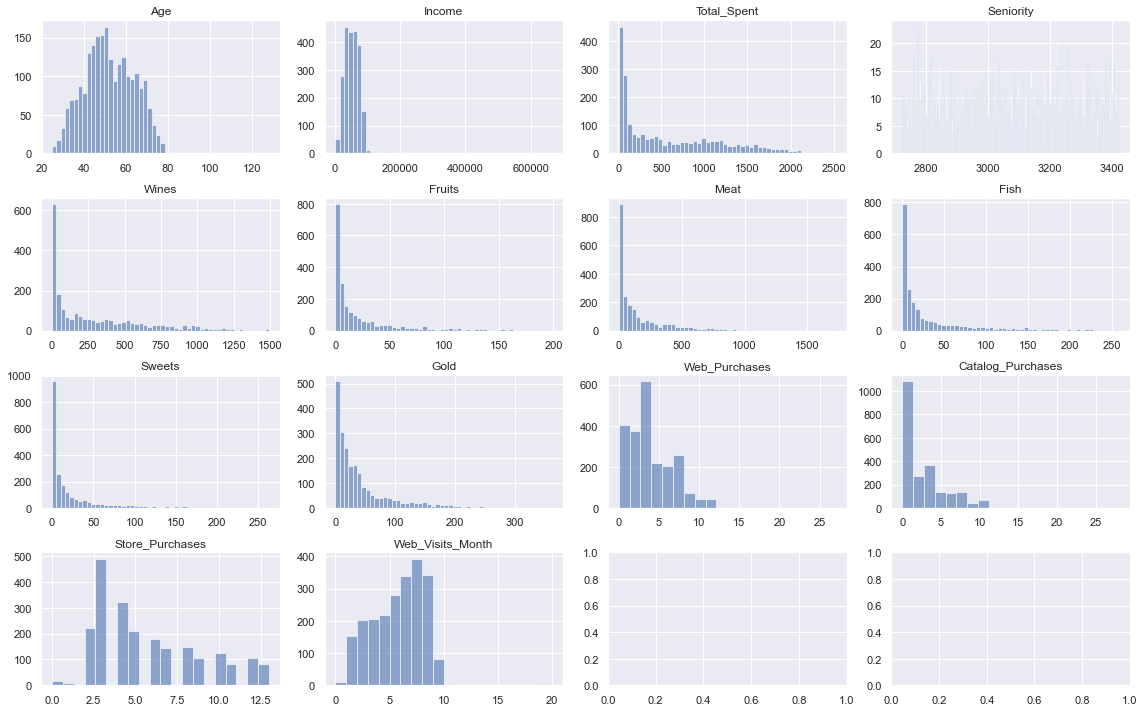

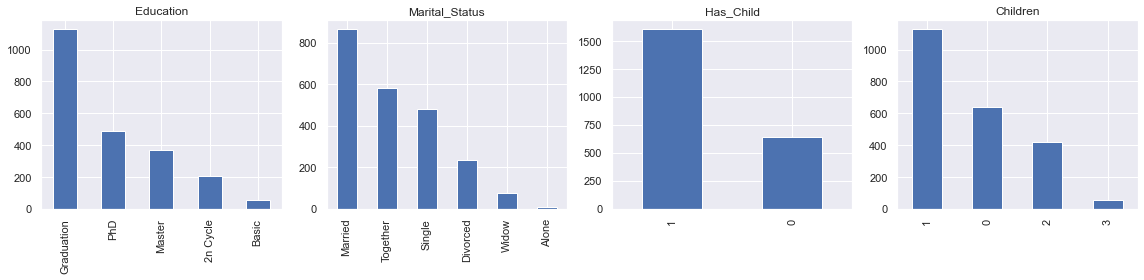

In [8]:
# Plot features after cleaning the data
hist_columns = ['Age', 'Income', 'Total_Spent', 'Seniority', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
bar_columns = ['Education', 'Marital_Status', 'Has_Child', 'Children']

bins = [50, 50, 50, 250, 50, 50, 50, 50, 50, 50, 20, 20, 20, 20]

plot_hist(hist_columns, bins)
plot_bars(bar_columns)

### Clean data

In [9]:
# Check amount of initial null values
print('Amount of null values',len(data[data.isna().any(axis=1)]))
print(data.mean().mean())

Amount of null values 24
3538.0089573797704


In [10]:
# Fill null values with mean income amount according its education level
data['Income'].fillna(data.groupby('Education')['Income'].transform('mean'), inplace=True)

In [11]:
# Check the amount of null values after cleaning the data
print('Amount of null values after cleaning the data',len(data[data.isna().any(axis=1)]))

Amount of null values after cleaning the data 0


In [12]:
# Remove outliers
data = data[data['Age'] < 100]
data = data[data['Income'] < 600000]

In [13]:
data.head()

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month
ID,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,3387,0,0,635,88,546,172,88,88,8,10,4,7
2174,67,Graduation,Single,46344.0,27,2837,1,2,11,1,6,2,1,6,1,1,2,5
4141,56,Graduation,Together,71613.0,776,3036,0,0,426,49,127,111,21,42,8,2,10,4
6182,37,Graduation,Together,26646.0,53,2863,1,1,11,4,20,10,3,5,2,0,4,6
5324,40,PhD,Married,58293.0,422,2885,1,1,173,43,118,46,27,15,5,3,6,5


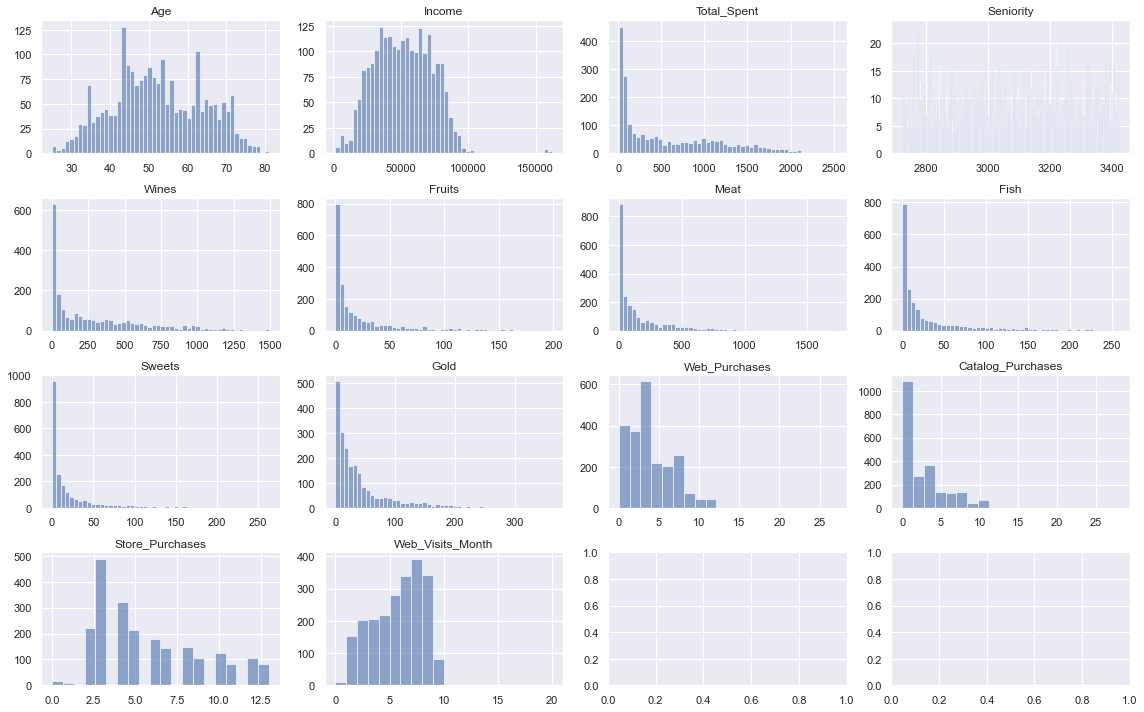

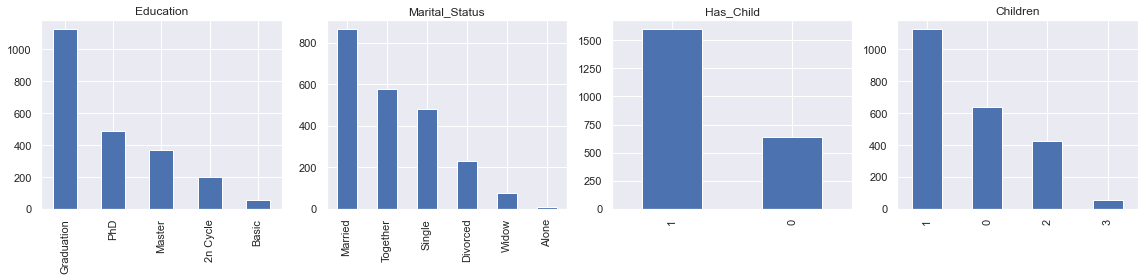

In [14]:
# Plot again after cleaning the data
plot_hist(hist_columns, bins)
plot_bars(bar_columns)

### Create Labels

In [15]:
# Adding labels to DataFrame
data['Buy_More_Online'] = (data['Web_Purchases'] > data['Store_Purchases'])*1
data['Spent_More_In_Wines_Than_Meat'] = (data['Wines'] > data['Meat'])*1

In [16]:
data = pd.get_dummies(data)
data.head()

,Age,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,...,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
ID,,,,,,,,,,,,,,,,,,,,,
5524,64,58138.0,1617,3387,0,0,635,88,546,172,...,0,1,0,0,0,0,0,1,0,0
2174,67,46344.0,27,2837,1,2,11,1,6,2,...,0,1,0,0,0,0,0,1,0,0
4141,56,71613.0,776,3036,0,0,426,49,127,111,...,0,1,0,0,0,0,0,0,1,0
6182,37,26646.0,53,2863,1,1,11,4,20,10,...,0,1,0,0,0,0,0,0,1,0
5324,40,58293.0,422,2885,1,1,173,43,118,46,...,0,0,0,1,0,0,1,0,0,0


### Prepare data

In [17]:
# Get own labels
y_online = data['Buy_More_Online']
y_spent = data['Spent_More_In_Wines_Than_Meat']

In [18]:
# Drop label columns
data.drop(columns=['Buy_More_Online', 'Spent_More_In_Wines_Than_Meat'], inplace=True)
data.head()

,Age,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,...,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
ID,,,,,,,,,,,,,,,,,,,,,
5524,64,58138.0,1617,3387,0,0,635,88,546,172,...,0,1,0,0,0,0,0,1,0,0
2174,67,46344.0,27,2837,1,2,11,1,6,2,...,0,1,0,0,0,0,0,1,0,0
4141,56,71613.0,776,3036,0,0,426,49,127,111,...,0,1,0,0,0,0,0,0,1,0
6182,37,26646.0,53,2863,1,1,11,4,20,10,...,0,1,0,0,0,0,0,0,1,0
5324,40,58293.0,422,2885,1,1,173,43,118,46,...,0,0,0,1,0,0,1,0,0,0


## Unsupervised Learning

In [19]:
# Standarize data
numeric_columns = ['Age', 'Income','Seniority','Total_Spent', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
scaler = StandardScaler()

X_Standarized = scaler.fit(data[numeric_columns]).transform(data[numeric_columns])
X_Standarized

array([[ 1.01686817,  0.28819509,  1.52979289, ...,  2.50980125,
        -0.55242921,  0.69286459],
       [ 1.27326389, -0.26271505, -1.19114282, ..., -0.56896988,
        -1.16773767, -0.13142124],
       [ 0.33314626,  0.91762651, -0.20665881, ..., -0.2268842 ,
         1.29349615, -0.54356416],
       ...,
       [-1.03429758,  0.23415041, -0.98336227, ...,  0.11520148,
         2.21645883,  0.28072168],
       [ 1.10233341,  0.80701474, -0.97841512, ...,  0.79937285,
         1.29349615, -0.95570708],
       [ 1.27326389,  0.04207456,  1.3269595 , ..., -0.56896988,
        -0.55242921,  0.69286459]])

In [20]:
#Concat standarized data with dummy/indicator variables
cat_cols = [c for c in data.columns if c not in numeric_columns]
X_Standarized = pd.DataFrame(X_Standarized, columns=numeric_columns)
X_complete = pd.concat([X_Standarized, data[cat_cols].reset_index(drop=True)], axis=1)
X_complete

,Age,Income,Seniority,Total_Spent,Wines,Fruits,Meat,Fish,Sweets,Gold,...,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,1.016868,0.288195,1.529793,1.680176,0.983228,1.554170,1.679746,2.461068,1.475396,0.845669,...,0,1,0,0,0,0,0,1,0,0
1,1.273264,-0.262715,-1.191143,-0.962202,-0.871064,-0.636431,-0.713455,-0.650414,-0.631638,-0.729742,...,0,1,0,0,0,0,0,1,0,0
2,0.333146,0.917627,-0.206659,0.282541,0.362159,0.572177,-0.177201,1.344595,-0.147262,-0.038098,...,0,1,0,0,0,0,0,0,1,0
3,-1.290693,-1.182829,-1.062517,-0.918994,-0.871064,-0.560893,-0.651409,-0.503991,-0.583200,-0.748954,...,0,1,0,0,0,0,0,0,1,0
4,-1.034298,0.295435,-0.953679,-0.305762,-0.389661,0.421101,-0.217088,0.154911,-0.001950,-0.556831,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,0.162216,0.432299,0.134695,1.221499,1.203128,0.421101,0.066551,0.081700,2.201960,3.900428,...,0,1,0,0,0,0,1,0,0,0
2232,1.956986,0.562669,-1.656175,-0.269201,0.302727,-0.661610,-0.607091,-0.687019,-0.655857,-0.691317,...,0,0,0,1,0,0,0,0,1,0
2233,-1.034298,0.234150,-0.983362,1.055312,1.794481,0.546997,0.221666,-0.101329,-0.365231,-0.383920,...,0,1,0,0,0,1,0,0,0,0
2234,1.102333,0.807015,-0.978415,0.393886,0.368102,0.093769,0.208371,0.777208,0.070707,0.326936,...,0,0,1,0,0,0,0,0,1,0


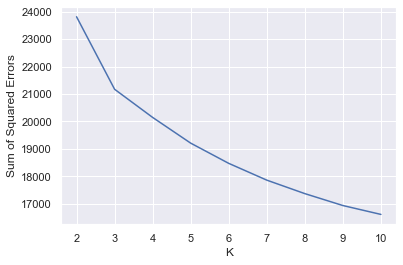

In [21]:
from sklearn.cluster import KMeans

def plot_sse(features_X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(X_complete)

In [22]:
# Get KMeans labels
labels = KMeans(n_clusters=3, random_state=0).fit_predict(X_complete)

In [23]:
data['Cluster'] = labels
data

,Age,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,...,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Cluster
ID,,,,,,,,,,,,,,,,,,,,,
5524,64,58138.0,1617,3387,0,0,635,88,546,172,...,1,0,0,0,0,0,1,0,0,2
2174,67,46344.0,27,2837,1,2,11,1,6,2,...,1,0,0,0,0,0,1,0,0,0
4141,56,71613.0,776,3036,0,0,426,49,127,111,...,1,0,0,0,0,0,0,1,0,1
6182,37,26646.0,53,2863,1,1,11,4,20,10,...,1,0,0,0,0,0,0,1,0,0
5324,40,58293.0,422,2885,1,1,173,43,118,46,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,54,61223.0,1341,3105,1,1,709,43,182,42,...,1,0,0,0,0,1,0,0,0,1
4001,75,64014.0,444,2743,1,3,406,0,30,0,...,0,0,1,0,0,0,0,1,0,1
7270,40,56981.0,1241,2879,0,0,908,48,217,32,...,1,0,0,0,1,0,0,0,0,1


In [24]:
from sklearn.decomposition import PCA

X_reduced_pca = PCA(n_components=3).fit(X_complete).transform(X_complete)

print("The features of the first sample are: %s" % X_reduced_pca[0])

The features of the first sample are: [ 4.28750014 -1.26239593  1.38712267]


Text(0.5, 0, 'PCA')

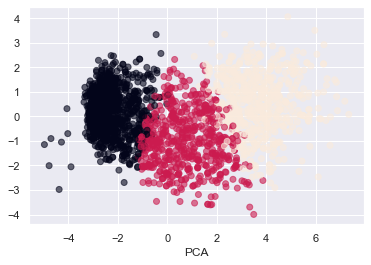

In [25]:
# Plot the data reduced in 2d space with PCA
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)
plt.xlabel("PCA")

In [26]:
X_reduced_pca

array([[ 4.28750014, -1.26239593,  1.38712267],
       [-2.46435837,  1.15686201, -1.43648867],
       [ 1.874997  , -0.1113001 , -0.36504247],
       ...,
       [ 1.55608433,  0.46080398, -0.00724212],
       [ 1.8663309 ,  0.35450761, -1.66819641],
       [-1.83461583, -1.19474911, -0.84141732]])

In [27]:
X_reduced_pca[:,0]

array([ 4.28750014, -2.46435837,  1.874997  , ...,  1.55608433,
        1.8663309 , -1.83461583])

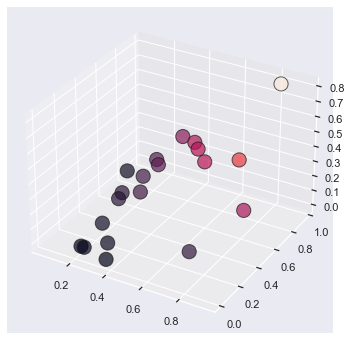

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

x = np.random.rand(20)
y = np.random.rand(20)
z = x*y

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
plt.show()


## Supervised Learning

### First Model: (Online purchases vs storage purchases)

In [29]:
# Split data in training and testing sets (80% train - 20% test)
x_train, x_test, y_train, y_test = train_test_split(data, y_online, test_size = 0.20)

#### Standarization

In [30]:
# Standarize data
numeric_columns = ['Age', 'Income','Seniority','Total_Spent', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
scaler = StandardScaler()

X_Train_Standarized = scaler.fit(x_train[numeric_columns]).transform(x_train[numeric_columns])
X_Test_Standarized = scaler.transform(x_test[numeric_columns])
X_Train_Standarized

array([[ 1.18333623,  1.15745595,  0.89631984, ...,  1.8482564 ,
         0.68876415,  0.27790661],
       [ 0.67099338,  0.45306823, -0.06876677, ..., -0.57402392,
        -0.55361699, -0.97267314],
       [-1.97611134, -0.80796101,  0.10357012, ..., -0.57402392,
        -0.55361699,  0.69476653],
       ...,
       [ 0.75638386, -0.14357036, -0.5611579 , ..., -0.57402392,
         0.68876415,  0.27790661],
       [ 1.86646003,  0.74248631,  0.61073299, ...,  1.8482564 ,
        -0.55361699,  0.27790661],
       [ 1.52489813, -1.40006722, -1.28497286, ..., -0.92006397,
        -0.86421227,  0.27790661]])

In [31]:
#Concat standarized data with dummy/indicator variables
cat_cols = [c for c in x_train.columns if c not in numeric_columns]
X_Train_Standarized = pd.DataFrame(X_Train_Standarized, columns=numeric_columns)
X_Train_complete = pd.concat([X_Train_Standarized, x_train[cat_cols].reset_index(drop=True)], axis=1)

X_Test_Standarized = pd.DataFrame(X_Test_Standarized, columns=numeric_columns)
X_Test_complete = pd.concat([X_Test_Standarized, x_test[cat_cols].reset_index(drop=True)], axis=1)

#### Train Model (Stochastic Gradient Descent)

In [32]:
# Stochastic Gradient Descent
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=200, alpha=0.1)

sgd.fit(X_Train_complete, y_train)
predict_sgd = sgd.predict(X_Test_complete)
print(predict_sgd)

[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0]


### Plot Confusion Matrix (Second Model)

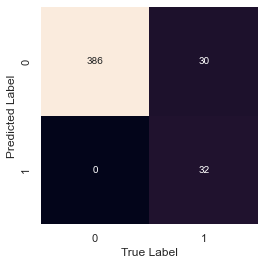

In [33]:
matrix = confusion_matrix(y_test, predict_sgd)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('True Label')
plt.ylabel('Predicted Label');
plt.show()

### Calculate classifier's metrics

In [34]:
accuracy = accuracy_score(y_test, predict_sgd)
print(f"Accuracy Score: {accuracy} ")
precision = precision_score(y_test, predict_sgd, average="binary", zero_division=1)
print(f"Precision Score: {precision} ")
recall = recall_score(y_test, predict_sgd, average="binary")
print(f"Recall Score: {recall} ")
f1score = f1_score(y_test, predict_sgd, average="binary")
print(f"F1 Score: {f1score} ")

Accuracy Score: 0.9330357142857143 
Precision Score: 1.0 
Recall Score: 0.5161290322580645 
F1 Score: 0.6808510638297872 


### Second Model: (Spent more in Wine than Meat)

In [35]:
# Split data in training and testing sets (80% train - 20% test)
x_train, x_test, y_train, y_test = train_test_split(data, y_spent, test_size = 0.20)

In [36]:
# Standarize data
numeric_columns = ['Age', 'Income','Seniority','Total_Spent', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
scaler = StandardScaler()

X_Train_Standarized = scaler.fit(x_train[numeric_columns]).transform(x_train[numeric_columns])
X_Test_Standarized = scaler.transform(x_test[numeric_columns])

In [37]:
#Concat standarized data with dummy/indicator variables
cat_cols = [c for c in x_train.columns if c not in numeric_columns]
X_Train_Standarized = pd.DataFrame(X_Train_Standarized, columns=numeric_columns)
X_Train_complete = pd.concat([X_Train_Standarized, x_train[cat_cols].reset_index(drop=True)], axis=1)

X_Test_Standarized = pd.DataFrame(X_Test_Standarized, columns=numeric_columns)
X_Test_complete = pd.concat([X_Test_Standarized, x_test[cat_cols].reset_index(drop=True)], axis=1)

#### Train Model (Naive Bayes)

In [38]:
# Naive Bayes
gnb = GaussianNB()

gnb.fit(X_Train_complete, y_train)
predict_gnb = gnb.predict(X_Test_complete)
print(predict_gnb)

[1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1
 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0
 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1
 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0
 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0]


### Plot Confusion Matrix (Second Model)

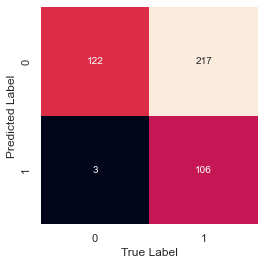

In [39]:
matrix = confusion_matrix(y_test, predict_gnb)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('True Label')
plt.ylabel('Predicted Label');
plt.show()

### Calculate classifier's metrics

In [40]:
accuracy = accuracy_score(y_test, predict_gnb)
print(f"Accuracy Score: {accuracy} ")
precision = precision_score(y_test, predict_gnb, average="binary", zero_division=1)
print(f"Precision Score: {precision} ")
recall = recall_score(y_test, predict_gnb, average="binary")
print(f"Recall Score: {recall} ")
f1score = f1_score(y_test, predict_gnb, average="binary")
print(f"F1 Score: {f1score} ")

Accuracy Score: 0.5089285714285714 
Precision Score: 0.9724770642201835 
Recall Score: 0.3281733746130031 
F1 Score: 0.49074074074074076 
